In [0]:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ReLU, BatchNormalization, Dropout, SeparableConv2D
from tensorflow.keras import optimizers
import numpy as np
import os
import sys
from six.moves import cPickle
import tensorflow as tf
import matplotlib.pyplot as plt

# hyper parameter
batch_size = 32
num_classes = 100
epochs = 40

# 데이터 총 개수 : 40000개
# 클래스 개수 : 100개, 클래스 별 400개 이미지

steps_per_epoch = int(40000/batch_size)
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'trained_model.h5'

In [0]:
import sklearn.model_selection as sk
from google.colab import drive


# train_data 가져오기 
def load_data():
    path = './'

    fpath = os.path.join(path, 'train_data')
    
    with open(fpath, 'rb') as f:
        d = cPickle.load(f, encoding='bytes')
        
    X_train = d['data']
    y_train = d['labels']
    y_train = np.reshape(y_train, (len(y_train), 1))

    return X_train, y_train

x_train, y_train = load_data()


# test, train dataset 분류하기 
# validation accuracy를 확인하기 위해 train과 test데이터로 나누었다.
X_train, X_test, y_train, y_test = sk.train_test_split(x_train,
                                                    y_train,
                                                    test_size=0.33,
                                                    random_state=42,
                                                    shuffle=True)


In [7]:
# normalize image data
# 이미지 데이터 전처리

# 데이터 학습이 잘 일어나도록 데이터들을 center에 맞춰주었다.
# 차이를 확실히 보이기 위해 전처리 전과 후 평균과 분산 값을 출력해보았다.

print ("mean before normalization:", np.mean(X_train)) 
print ("std before normalization:", np.std(X_train))

mean=[0,0,0]
std=[0,0,0]

newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)

for i in range(3):
    mean[i] = np.mean(X_train[:,:,:,i])
    std[i] = np.std(X_train[:,:,:,i])
       
for i in range(3):
    newX_train[:,:,:,i] = X_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = X_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]

X_train = newX_train
X_test = newX_test

print ("mean after normalization:", np.mean(X_train))
print ("std after normalization:", np.std(X_train))
print(X_train.max())

mean before normalization: 121.98364992663635
std before normalization: 68.30227829343998
mean after normalization: 5.568237965794131e-17
std after normalization: 0.9999999999999987
2.025461104398623


In [0]:
# label preprocessing
# 클래스 벡터(정수들)를 바이너리 클래스 매트릭스로 변환한다.
# 보통 'categorical_crossentropy' 와 같이 쓰인다.

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
# make dataset
# 이미지 데이터와 라벨 데이터로 dataset을 생성했다.

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
val_dataset = val_dataset.batch(32)

In [0]:
from tensorflow.keras.callbacks import LearningRateScheduler

callbacks = [
  tf.keras.callbacks.EarlyStopping(patience=4, monitor='val_loss')
]

# callbacks 함수 추가
# 의미없이 epoch 을 돌지 않도록 val_loss 값이 4번 연속 상승하면 자동으로 학습을 중지하도록 했다.

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

# scheduler 함수 추가 
# 각 epoch 마다 learning rate 을 조절한다. 
# epoch 10 미만이면 0.001이고 10부터 rate 값이 소폭 감소하기 시작한다. 

In [0]:
from tensorflow.keras.regularizers import l2
from keras.optimizers import adam


# create model 

# 효과적으로 학습을 위해 각 layer에 다음과 같은 방법을 사용했다. 

# 1. kernel_initializer = 'he_uniform' 
# 초기값 설정은 'he_uniform' 방법을 사용했다.

# 2. kernel_regularizer=12(0.001), bias_regularizerr=l2(0.001)
# weight regularization 으로 l2를 사용했다.
# l2는 l1과 다르게 가중치를 완전히 0으로 만들지는 않기 때문에 l1보다 효과적이다.
# rate 값으로 0.001을 사용했다. 다른 값들보다 0.001이 가장 학습이 잘 일어난다.

# 3. activation = 'relu'
# 활성화 함수로 relu를 사용했다. 

# 4. Add BatchNormalization
# 학습 성능을 높여주기 위해 layer마다 배치 정규화를 시켜주었다. 

# 5. Add Dropout 
# overfit을 방지하기 위해 특정 노드를 제거하는 dropout을 추가했다.
# 각 layer마다 0.25 dropout을 지정해주었고, 마지막 레이어에는 0.5 dropout을 지정했다.

# 6. adam = optimizers.Adam(lr = 0.001, decay=1e-5)
# optimize방법으로 가장 효과가 좋은 adam으로 설정했다. 
# learning rate 는 0.001, decay값으로 1e-5으로 설정했다.  

# 7. Add Layer
# 기존 모델에서 총 4개의 layer를 추가했다. 


def create_model():
  model = Sequential()

  # layer1
  model.add(Conv2D(64, (3, 3), 
                    padding='same',
                    input_shape=X_train.shape[1:],
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001),
                    activation='relu'
                    ))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  # layer2
  model.add(Conv2D(64, (3, 3), 
                    padding='same',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001),
                    activation='relu'
                    ))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  # layer3
  model.add(Conv2D(128, (3, 3), 
                    kernel_initializer='he_uniform',
                    activation='relu',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001),
                    padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  # layer4
  model.add(Conv2D(256, (3, 3),
                    kernel_initializer='he_uniform', 
                    activation='relu',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001),
                    padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))
  
  # layer5
  model.add(Conv2D(512, (3, 3), 
                    kernel_initializer='he_uniform',
                    activation='relu',
                    kernel_regularizer=l2(0.001),
                    bias_regularizer=l2(0.001),
                    padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(512, 
                  kernel_initializer='he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(num_classes,
                  kernel_initializer='he_uniform',
                  kernel_regularizer=l2(0.001),
                  bias_regularizer=l2(0.001),
                  activation='softmax'))

  adam = optimizers.Adam(lr = 0.001, decay=1e-5)

  model.compile(loss='categorical_crossentropy',
                optimizer=adam,
                metrics=['accuracy'])
  
  return model


In [12]:
# 학습 모델 만들기 
model = create_model()

# 이미지 학습 시키기 
history = model.fit(dataset, 
           epochs=epochs,
           shuffle=True,
           validation_data=val_dataset,
           callbacks=[LearningRateScheduler(scheduler, verbose=1), callbacks],
           workers=4)

# 이미지 학습 옵션 추가
# 1. shuffle = True 
# 랜덤하게 데이터 학습하기 위해 추가한 옵션이다.
# 2. callbacks=[LearningRateScheduler(scheduler, verbose=1), callbacks]
# 아까 만든 콜백 함수들을 모델 학습시킬 때 적용했다.

# 정확도 찍어보기 
results = model.evaluate(X_test, y_test)
print('Test accuracy: ', results[1])


# 학습 결과
# accuracy: 0.9234 - val_loss: 2.7191 - val_accuracy: 0.5702 - lr: 5.5023e-05
# Test accuracy:  0.5701515078544617

# accuracy 값은 높이 나오지만 val_accuracy값과 차이가 나는 overfitting 현상을 보이고 있다.
# 그러나 epoch 돌 때마다  val_accuracy 값이 소폭으로 증가하고 있다. 
# val_loss 값 역시 epoch 돌 때마다 소폭으로 감소하고 있다. 


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/40
838/838 [==============================] - 12s 14ms/step - loss: 11.8055 - accuracy: 0.0525 - val_loss: 13.4252 - val_accuracy: 0.0893 - lr: 0.0010

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
Epoch 2/40
838/838 [==============================] - 13s 15ms/step - loss: 7.4116 - accuracy: 0.1113 - val_loss: 5.7220 - val_accuracy: 0.1914 - lr: 0.0010

Epoch 00003: LearningRateScheduler reducing learning rate to 0.001.
Epoch 3/40
838/838 [==============================] - 13s 15ms/step - loss: 5.3966 - accuracy: 0.1844 - val_loss: 4.8712 - val_accuracy: 0.2628 - lr: 0.0010

Epoch 00004: LearningRateScheduler reducing learning rate to 0.001.
Epoch 4/40
838/838 [==============================] - 13s 16ms/step - loss: 4.4530 - accuracy: 0.2556 - val_loss: 4.2304 - val_accuracy: 0.3155 - lr: 0.0010

Epoch 00005: LearningRateScheduler reducing learning rate to 0.001.
Epoch 5/40
838/838 [=====

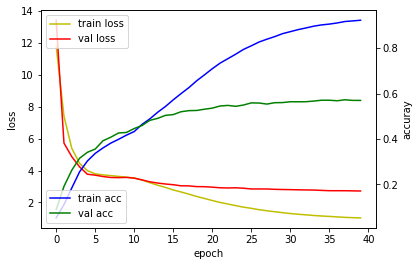

In [13]:
# 결과를 한 눈에 확인하기 위해 plot에 그래프를 그려보았다. 
# train loss, val loss, train acc, val acc 를 그렸다.

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()


# epoch 20 이후 부터는 val acc 값이 소폭으로 상승하기 시작한다.
# val loss 값 역시 epoch 20부터 소폭으로 감소하기 시작한다. 

In [14]:
# save model

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/saved_models/trained_model.h5 
